In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import sklearn.decomposition
from skimage.transform import resize

%matplotlib inline

## Helper Functions

In [1]:
def load_data(path, col_name):
    """
    Load input data from matlab file.
    
    Parameters
    ----------
    path : String
        The relative path of matlab file    
    col_name : String
        Label of the input data within the
        file
    
    Returns
    -------
    N x D matrix
        Contains the resized image data
        where each column represents an
        image
    
    N x num_labels matrix
        Contains the one-hot encoded form
        of each data point's classification
    """
    resize_width = 17
    resize_height = 20
    
    ip = sio.loadmat(path)

    N = ip[col_name].shape[1] * ip[col_name][:, 0][0].shape[2]
    num_labels = ip[col_name].shape[1]

    size = (resize_height, resize_width)
    X = np.zeros((N, resize_height * resize_width))

    img_index = 0

    for i in range(num_labels):
        curr_class_data = ip[col_name][:,i][0]
        for j in range(curr_class_data.shape[2]):
            img_resized = resize(curr_class_data[:,:,j], size, mode='constant')
            X[img_index, :] = img_resized.flatten()
            img_index += 1
    
    return X

def plot_mse(M):
    iters = [(i + 1) for i in range(len(M))]
    plt.plot(iters, M, 'k-')
    plt.xlabel('Iterations')
    plt.ylabel('MSE')

def compute_mse(actual, reconstructed):
    """
    Computes the mean square error while
    reconstructing the input from encoded
    data.
    
    Parameters
    ----------
    actual : N x D matrix        
        Contains the actual input
    reconstructed : N x D matrix
        Constains the reconstructed points
        from decode layer
    
    Returns
    -------
    Double
        The calculated MSE
    """
    diff = actual - reconstructed
    return np.sum(np.sum(np.square(diff), axis=1), axis=0) / actual.shape[0]

def tanh_derivative(data):
    """
    Computes the derivative after executing
    tanh function on the given data
    
    Parameters
    ----------
    data : N x D matrix
        The input data
    
    Returns
    -------
    N x D matrix
        The tanh derivative of the data
    """
    th = np.tanh(data)
    return 1 - th*th

def relu(data):
    """
    Applies the ReLU activation function on
    data passed as argument
    
    Parameters
    ----------
    data : N x D matrix
        The input data
       
    Returns
    -------
    N x D matrix
        The ReLU applied data
    """
    return np.maximum(data, 0)

def relu_derivative(data):
    """
    Applies the derivative of ReLU activation
    function on the data as argument
    
    Parameters
    ----------
    data : N x D matrix
        The input data
       
    Returns
    -------
    N x D matrix
        The ReLU derivative applied data
    """
    np.putmask(data, data > 0, 1)
    np.putmask(data, data < 0, 0)
    return data

def sigmoid(Z):
    """
    Applies the sigmoid activation function: 
    1 / (1 + e ^ (-z)) where z represents
    each data point.
    
    Parameters
    ----------
    Z : N x D matrix
        The data
    
    Returns
    -------
    N x D matrix
        The data with sigmoid activation
        function applied on it
    """    
    return 1 / (1 + (np.exp(-Z)))

def sigmoid_derivative(Z):
    """
    Applies the derivative of sigmoid
    activation function: 1 / (1 + e ^ (-z))
    where z represents each data point.
    
    Parameters
    ----------
    Z : N x D matrix
        The data
    
    Returns
    -------
    N x D matrix
        The data with sigmoid activation
        function applied on it
    """
    partial = 1 / (1 + (np.exp(-Z)))
    return np.multiply(partial, (1 - partial))

## Auto Encoder

In [1]:
class AutoEncoder:
    
    def __init__(self, f_activation, f_derivative, n_input, n_hidden, alpha = 0.1, bias = 1.0, l1_penalty = 0.01, mse_threshold = 3):
        
        # Initialize learning rate and bias
        self.alpha = alpha
        self.bias = bias
        self.l1_penalty = l1_penalty
        self.mse_threshold = mse_threshold
        
        # Store the activation function to be used by each neuron
        self.f_activation = f_activation
        self.f_derivative = f_derivative
        
        # Store the number of neurons in each layer
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_input
        
        # Initialize the weights and biases for hidden and output layers
        # Dimension of weight matrix for layer l: S[l+1] x S[l]
        self.W1 = np.random.normal(0, 1, [self.n_hidden, self.n_input + 1])
        self.W2 = np.random.normal(0, 1, [self.n_output, self.n_hidden + 1])
        
        # Initialize variables to store the input to neuron in each layer
        # Dimension of input vector for layer l: S[l]x1
        self.z2 = np.zeros((self.n_hidden, 1), dtype=float)
        self.z3 = np.zeros((self.n_output, 1), dtype=float)
        
        # Initialize variables to store the output for neurons in all layers
        # Dimension of output vector for layer l: (S[l]+1)x1
        self.a1 = np.zeros((self.n_input + 1, 1), dtype=float)
        self.a2 = np.zeros((self.n_hidden + 1, 1), dtype=float)
        self.a3 = np.zeros((self.n_output, 1), dtype=float)
        
        # Initialize variables to store the intermediate deltas
        # Dimension of delta vectors for layer l: S[l] x 1
        self.d2 = np.zeros((self.n_hidden), dtype=float)
        self.d3 = np.zeros((self.n_output), dtype=float)        
    
    def propogate_forward(self, curr_datapoint):
        """
        Performs forward propogation to calculate
        the inputs to neurons in the hidden and
        output layers.
        
        Parameters
        ----------
        curr_datapoint: a 1xD row vector which has the
            first data point
        """
        
        # Output from input layer will be the data passed as input
        # a1 -> D x 1 vector
        self.a1[:-1, 0] = curr_datapoint.T
        self.a1[-1:, 0] = self.bias
        
        # Hidden layer
        # z2 -> n_hidden x 1 vector
        # a2 -> (n_hidden + 1) x 1 vector
        self.z2 = np.dot(self.W1, self.a1)
        self.a2[:-1, :] = self.f_activation(self.z2)
        self.a2[-1:, :] = self.bias
        
        # Output layer
        # z3 -> n_output x 1 vector
        # a3 -> n_output x 1 vector
        self.z3 = np.dot(self.W2, self.a2)
        self.a3 = self.f_activation(self.z3)
    
    def propogate_back(self, y):
        """
        Performs backward propogation to calculate
        the partial derivative of cost function
        with respect to weights and bias terms 
        using intermediate values calculated during
        the forward propogation step.
        
        Parameters
        ----------
        y : a n_output x 1 vector
            which stores the actual class of
            the input
        """
        
        # Calculate delta from output layer
        # d3 -> n_output x 1 vector
        self.d3 = self.a3 - np.reshape(y, (self.n_output, 1))
        
        # Calculate delta from hidden layer
        # d2 -> n_hidden x 1 vector
        z2_derivative = self.f_derivative(self.z2)
        self.d2 = np.multiply(
                    np.dot(self.W2[:, :-1].T, self.d3), 
                    z2_derivative)
    
    def train(self, data):
        """
        Train the neural network with given data.
        
        Parameters
        ----------
        data : a N x D matrix
            where D is the number of dimensions &
            N is the number of data points.
            Contains the input data in the form
            of a matrix
        
        Returns
        -------
        (n_hidden + 1) x 1 vector
            Stores the weights for inputs of hidden 
            layer
        (n_output + 1) x 1 vector
            Stores the weights for inputs of output
            layer
        List<Double>
            The MSEs calculated for every 50th 
            iteration
        """
        
        N = data.shape[0]  # Each row represents a data point
        
        count = 0
        errors = []
        while(True):
            # Initialize variables to store the change in weight variables
            # Dimension of matrix for layer l: S[l+1] x S[l]
            D1 = np.matrix(np.zeros((self.n_hidden, self.n_input + 1), dtype=float))
            D2 = np.matrix(np.zeros((self.n_output, self.n_hidden + 1), dtype=float))

            for i in range(N):
                curr_datapoint = data[i, :]

                self.propogate_forward(curr_datapoint)
                self.propogate_back(curr_datapoint)
                
                D1[:, :-1] += np.dot(self.d2, self.a1[:-1, :].T)
                D1[:, -1:] += self.d2
                D2[:, :-1] += np.dot(self.d3, self.a2[:-1, :].T)
                D2[:, -1:] += self.d3
        
            # Update weights
            self.W1 -= self.alpha * ((1/N) * D1 + self.l1_penalty * self.W1)
            self.W2 -= self.alpha * ((1/N) * D2 + self.l1_penalty * self.W2)
            
            # Compute MSE for the generated weights
            ip_ones = np.ones((data.shape[0], 1))
            input_data = np.hstack((data, ip_ones))            
            encode_layer = np.dot(input_data, self.W1.T)
            encode_layer = self.f_activation(encode_layer)
            
            decode_ones = np.ones((encode_layer.shape[0], 1))
            decode_layer = np.hstack((encode_layer, decode_ones))
            decode_layer = np.dot(decode_layer, self.W2.T)
            
            reconstructed = self.f_activation(decode_layer)
            mse = compute_mse(data, reconstructed)
            errors.append(mse)
            
            # Check for convergence
            if (mse <= self.mse_threshold):
                print("Final MSE from training: ", mse)
                break
                
            if (count % 50 == 0):                
                print(count, ": ", mse)
            
            count += 1
        
        return self.W1, self.W2, errors, encode_layer

In [107]:
def train_auto_encoder(f_activation, f_derivative, alpha, bias, l1_penalty, mse_threshold=3):
    # Train the model
    X = load_data("ExtYaleB10.mat", 'train')
    an = AutoEncoder(f_activation, f_derivative, X.shape[1], 100, alpha, bias, l1_penalty, mse_threshold)
    we, wd, mse = an.train(X)
    plot_mse(mse)    
    print("Weights for encoding layer: ", we)
    print("Weights for decoding layer: ", wd)
    
    # Test the trained model
    test_data = load_data("ExtYaleB10.mat", 'test')

    ip_ones = np.ones((test_data.shape[0], 1))
    test_data = np.hstack((test_data, ip_ones))
    input_layer = np.dot(test_data, we.T)

    hidden_layer = np.tanh(input_layer)
    hidden_ones = np.ones((hidden_layer.shape[0], 1))
    hidden_layer = np.hstack((hidden_layer, hidden_ones))

    reconstructed = np.dot(hidden_layer, wd.T)
    reconstructed = np.tanh(reconstructed)

    print("MSE for test data: ", compute_mse(test_data[:, :-1], reconstructed))

0 :  313.462564286
50 :  269.70741412
100 :  261.41461738
150 :  255.370449556
200 :  244.873489143
250 :  240.844535789
300 :  227.661495296
350 :  217.202437363
400 :  208.713468389
450 :  206.497611554
500 :  201.011366865
550 :  182.31712478
600 :  187.786838218
650 :  175.876172749
700 :  162.099261525
750 :  151.218681397
800 :  145.196751245
850 :  132.736965024
900 :  125.813570743
950 :  124.726828401
1000 :  96.5536106243
1050 :  93.6355676071
1100 :  94.4378683789
1150 :  85.8555936856
1200 :  72.639368313
1250 :  56.657456065
1300 :  53.2557925068
1350 :  48.3186481705
1400 :  33.887655054
1450 :  22.8321293292
1500 :  15.2584445191
1550 :  13.0956636227
1600 :  9.35923444172
1650 :  7.3506447906
1700 :  5.53337692586
1750 :  4.53144776693
1800 :  3.20813217001
1850 :  4.17321585842
Final MSE from training:  2.98713057579
MSE for test data:  3.42507224073


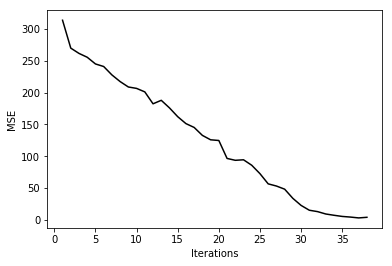

In [72]:
train_auto_encoder(np.tanh, tanh_derivative, alpha=0.1, bias=1.0, l1_penalty=0.01)

In [93]:
train_auto_encoder(relu, relu_derivative, alpha=0.1, bias=1.0, l1_penalty=0.01)

0 :  500424340.998
1 :  2.9481104413e+13
2 :  3.80495282386e+25
3 :  5.60638453376e+46
4 :  47.5602510987
5 :  47.5602510987
6 :  47.5602510987
7 :  47.5602510987
8 :  47.5602510987
9 :  47.5602510987
10 :  47.5602510987
11 :  47.5602510987
12 :  47.5602510987
13 :  47.5602510987
14 :  47.5602510987
15 :  47.5602510987
16 :  47.5602510987
17 :  47.5602510987
18 :  47.5602510987
19 :  47.5602510987
20 :  47.5602510987
21 :  47.5602510987
22 :  47.5602510987
23 :  47.5602510987
24 :  47.5602510987
25 :  47.5602510987
26 :  47.5602510987
27 :  47.5602510987
28 :  47.5602510987
29 :  47.5602510987
30 :  47.5602510987
31 :  47.5602510987
32 :  47.5602510987
33 :  47.5602510987
34 :  47.5602510987
35 :  47.5602510987
36 :  47.5602510987
37 :  47.5602510987
38 :  47.5602510987
39 :  47.5602510987
40 :  47.5602510987
41 :  47.5602510987
42 :  47.5602510987
43 :  47.5602510987
44 :  47.5602510987
45 :  47.5602510987
46 :  47.5602510987
47 :  47.5602510987
48 :  47.5602510987
49 :  47.5602510987

KeyboardInterrupt: 

0 :  98.9487156735
50 :  92.2797820324
100 :  86.235681489
150 :  81.1197151047
200 :  77.1398803425
250 :  73.9699874311
300 :  71.4080933099
350 :  69.5838410903
400 :  68.5505854697
450 :  68.0366362809
500 :  67.7828987539
550 :  67.6163993888
600 :  67.3998746591
650 :  67.0669606006
700 :  66.5791463833
750 :  65.8945872861
800 :  64.9944953329
850 :  63.8948783685
900 :  62.6306734746
950 :  61.2362629345
1000 :  59.7372774478
1050 :  58.1530728307
1100 :  56.5004738317
1150 :  54.7954899618
1200 :  53.0549366096
1250 :  51.2969062667
1300 :  49.5391855843
1350 :  47.7974482547
1400 :  46.0845382606
1450 :  44.4106198366
1500 :  42.7836235357
1550 :  41.2096825898
1600 :  39.6934791531
1650 :  38.2385056693
1700 :  36.8472611684
1750 :  35.5213988157
1800 :  34.2618378197
1850 :  33.0688509929
1900 :  31.9421369682
1950 :  30.8808831149
2000 :  29.8838225892
2050 :  28.9492874859
2100 :  28.0752598405
2150 :  27.2594227599
2200 :  26.499214232
2250 :  25.7918852056
2300 :  25.13

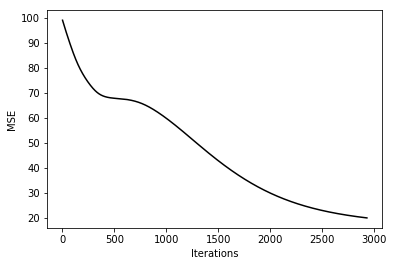

In [119]:
train_auto_encoder(sigmoid, sigmoid_derivative, alpha=0.001, bias=10.0, l1_penalty=1, mse_threshold=20)